# 3 — Greeks and Sensitivities

In this notebook we:

1. Define the main Black–Scholes Greeks: $\Delta$, $\Gamma$, $\nu$ (vega), $\Theta$, $\rho$.
2. Connect them to risk management and hedging interpretation.
3. Use our `option_pricing.greeks` module to compute Greeks.
4. Produce simple plots to visualize how Greeks depend on:
   - the underlying price $S_0$,
   - time to maturity $T$,
   - volatility $\sigma$.


In [1]:
import sys
from pathlib import Path

# Adjust this path if needed
project_root = Path(r"C:\Users\Ruben\Desktop\Projects\OptionPricing")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from option_pricing.greeks import (
    d1, d2,
    delta_call, delta_put,
    gamma, vega,
    theta_call, theta_put,
    rho_call, rho_put,
)
from option_pricing.black_scholes import black_scholes_call, black_scholes_put

import numpy as np
import math
import matplotlib.pyplot as plt

print("Project root:", project_root)


Project root: C:\Users\Ruben\Desktop\Projects\OptionPricing


## 1. Definitions of the main Greeks

Let $V(S_0, K, T, r, \sigma)$ be the price of an option (call or put).

The main Black–Scholes Greeks are:

- **Delta** $\Delta$ — sensitivity to the underlying price:
  $$
  \Delta = \frac{\partial V}{\partial S_0}.
  $$

- **Gamma** $\Gamma$ — sensitivity of delta to the underlying price:
  $$
  \Gamma = \frac{\partial^2 V}{\partial S_0^2}.
  $$

- **Vega** $\nu$ — sensitivity to volatility:
  $$
  \nu = \frac{\partial V}{\partial \sigma}.
  $$

- **Theta** $\Theta$ — sensitivity to the passage of time (time decay):
  $$
  \Theta = \frac{\partial V}{\partial T}.
  $$

- **Rho** $\rho$ — sensitivity to the risk-free rate:
  $$
  \rho = \frac{\partial V}{\partial r}.
  $$

They measure how the option price changes when each parameter moves by a small amount.
In practice, Greeks are used to hedge and manage the risks of an option portfolio.


### 1.1 Greeks for a European call (no dividends)

For a European **call** in Black–Scholes, the Greeks are:

- Delta:
  $$
  \Delta_{\text{call}} = N(d_1).
  $$

- Gamma:
  $$
  \Gamma = \frac{N'(d_1)}{S_0 \sigma \sqrt{T}},
  $$
  where $N'(x)$ is the standard normal density.

- Vega:
  $$
  \nu = S_0 N'(d_1) \sqrt{T}.
  $$

- Theta:
  $$
  \Theta_{\text{call}} =
  -\frac{S_0 N'(d_1) \sigma}{2 \sqrt{T}}
  - r K e^{-rT} N(d_2).
  $$

- Rho:
  $$
  \rho_{\text{call}} = K T e^{-rT} N(d_2).
  $$

For a **put**, formulas are similar but with sign changes for delta, theta, and rho.
We have implemented all of these in `option_pricing.greeks`.


In [2]:
S0 = 100.0
K = 100.0
T = 1.0      # 1 year
r = 0.02
sigma = 0.25

print("Base parameters:")
print(f"S0 = {S0}, K = {K}, T = {T}, r = {r}, sigma = {sigma}")


Base parameters:
S0 = 100.0, K = 100.0, T = 1.0, r = 0.02, sigma = 0.25


In [3]:
delta_c = delta_call(S0, K, T, r, sigma)
delta_p = delta_put(S0, K, T, r, sigma)
gamma_val = gamma(S0, K, T, r, sigma)
vega_val = vega(S0, K, T, r, sigma)
theta_c = theta_call(S0, K, T, r, sigma)
theta_p = theta_put(S0, K, T, r, sigma)
rho_c = rho_call(S0, K, T, r, sigma)
rho_p = rho_put(S0, K, T, r, sigma)

print(f"Call delta:  {delta_c:.4f}")
print(f"Put delta:   {delta_p:.4f}")
print(f"Gamma:       {gamma_val:.6f}")
print(f"Vega:        {vega_val:.4f}")
print(f"Call theta:  {theta_c:.4f}")
print(f"Put theta:   {theta_p:.4f}")
print(f"Call rho:    {rho_c:.4f}")
print(f"Put rho:     {rho_p:.4f}")


Call delta:  0.5812
Put delta:   -0.4188
Gamma:       0.015626
Vega:        39.0647
Call theta:  -5.8281
Put theta:   -3.8677
Call rho:    47.2508
Put rho:     -50.7690


## 2. Interpretation: delta as hedge ratio

For a small change $\Delta S_0$ in the underlying price, the option price approximately changes by

$$
\Delta V \approx \Delta \cdot \Delta S_0.
$$

For a **long call**, $\Delta_{\text{call}}$ is between $0$ and $1$.

- Deep out-of-the-money call: $\Delta \approx 0$.
- At-the-money call: $\Delta \approx 0.5$.
- Deep in-the-money call: $\Delta \approx 1$.

If we hold a long call and want to be **delta-neutral**, we can sell $\Delta$ units of the underlying per option contract (appropriately scaled by contract size). Delta hedging is dynamic: as $S_0$ changes, delta changes and the hedge must be updated.


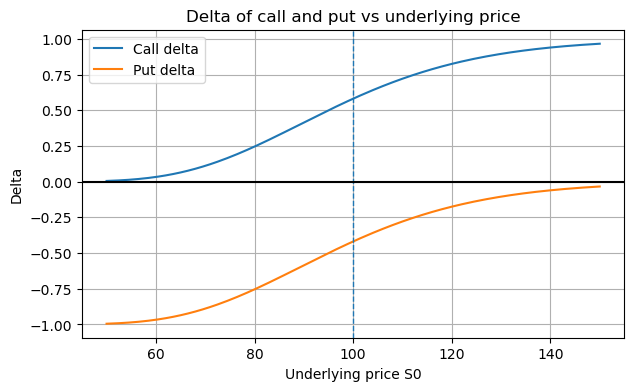

In [4]:
S_range = np.linspace(50, 150, 201)

d_call = [delta_call(S, K, T, r, sigma) for S in S_range]
d_put = [delta_put(S, K, T, r, sigma) for S in S_range]

plt.figure(figsize=(7, 4))
plt.plot(S_range, d_call, label="Call delta")
plt.plot(S_range, d_put, label="Put delta")
plt.axvline(K, linestyle="--", linewidth=1)
plt.xlabel("Underlying price S0")
plt.ylabel("Delta")
plt.title("Delta of call and put vs underlying price")
plt.legend()
plt.axhline(0, color="black", linewidth=1.5)
plt.grid(True)
plt.show()


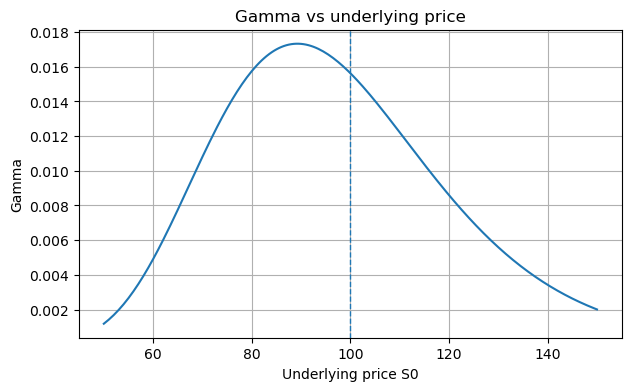

In [5]:
gamma_vals = [gamma(S, K, T, r, sigma) for S in S_range]

plt.figure(figsize=(7, 4))
plt.plot(S_range, gamma_vals)
plt.axvline(K, linestyle="--", linewidth=1)
plt.xlabel("Underlying price S0")
plt.ylabel("Gamma")
plt.title("Gamma vs underlying price")
plt.grid(True)
plt.show()


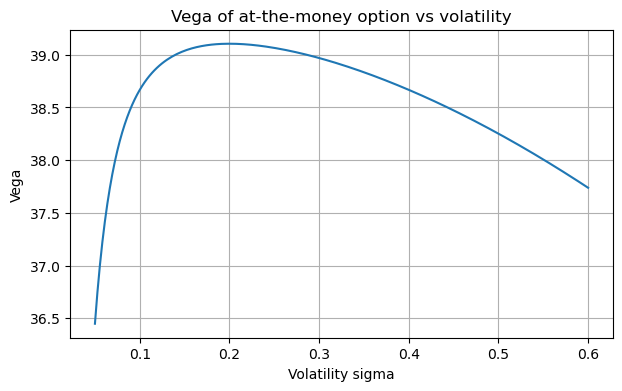

In [6]:
sigma_range = np.linspace(0.05, 0.60, 200)

vega_sigma = [vega(S0, K, T, r, s) for s in sigma_range]

plt.figure(figsize=(7, 4))
plt.plot(sigma_range, vega_sigma)
plt.xlabel("Volatility sigma")
plt.ylabel("Vega")
plt.title("Vega of at-the-money option vs volatility")
plt.grid(True)
plt.show()


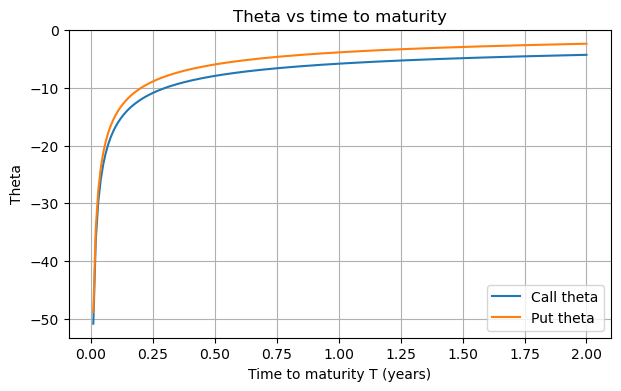

In [7]:
T_range = np.linspace(0.01, 2.0, 200)

theta_call_T = [theta_call(S0, K, T_, r, sigma) for T_ in T_range]
theta_put_T = [theta_put(S0, K, T_, r, sigma) for T_ in T_range]

plt.figure(figsize=(7, 4))
plt.plot(T_range, theta_call_T, label="Call theta")
plt.plot(T_range, theta_put_T, label="Put theta")
plt.xlabel("Time to maturity T (years)")
plt.ylabel("Theta")
plt.title("Theta vs time to maturity")
plt.legend()
plt.grid(True)
plt.show()


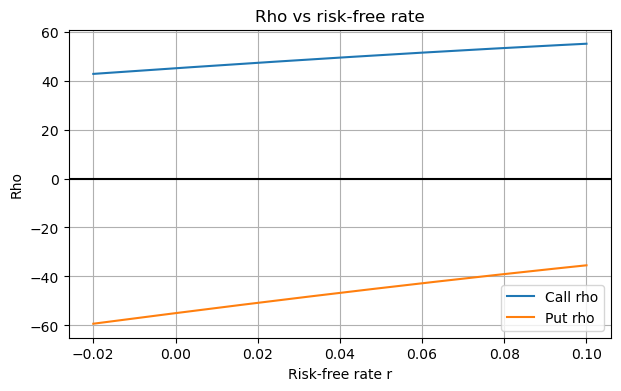

In [8]:
r_range = np.linspace(-0.02, 0.10, 200)

rho_call_r = [rho_call(S0, K, T, r_, sigma) for r_ in r_range]
rho_put_r = [rho_put(S0, K, T, r_, sigma) for r_ in r_range]

plt.figure(figsize=(7, 4))
plt.plot(r_range, rho_call_r, label="Call rho")
plt.plot(r_range, rho_put_r, label="Put rho")
plt.xlabel("Risk-free rate r")
plt.ylabel("Rho")
plt.title("Rho vs risk-free rate")
plt.legend()
plt.axhline(0, color="black", linewidth=1.5)
plt.grid(True)
plt.show()


In [9]:
h = 0.01

def finite_difference_gamma(S0, K, T, r, sigma, h):
    c_plus = black_scholes_call(S0 + h, K, T, r, sigma)
    c_minus = black_scholes_call(S0 - h, K, T, r, sigma)
    c_0 = black_scholes_call(S0, K, T, r, sigma)
    return (c_plus - 2 * c_0 + c_minus) / (h * h)

gamma_analytic = gamma(S0, K, T, r, sigma)
gamma_fd = finite_difference_gamma(S0, K, T, r, sigma, h)

print(f"Analytic gamma:        {gamma_analytic:.8f}")
print(f"Finite-difference gamma: {gamma_fd:.8f}")
print(f"Difference:            {gamma_fd - gamma_analytic:.3e}")


Analytic gamma:        0.01562588
Finite-difference gamma: 0.01562588
Difference:            -3.534e-10


# Conclusion

In this notebook we:

- Reviewed the main Greeks: $\Delta$, $\Gamma$, $\nu$, $\Theta$, $\rho$.
- Computed them for a base case using our `option_pricing.greeks` module.
- Interpreted delta as a hedge ratio and gamma as the sensitivity of delta.
- Plotted:
  - call and put delta vs underlying price,
  - gamma vs underlying price,
  - vega vs volatility,
  - theta vs time to maturity,
  - rho vs interest rate.
- Verified gamma numerically using a finite-difference approximation.

These plots show how option sensitivities concentrate near the strike (for gamma and vega)
and how time decay (theta) and interest-rate sensitivity (rho) behave over different maturities and rates.

In **notebook 4 — Strategies and P&L**, we will combine options into simple strategies
(bull call spread, protective put, covered call, etc.), compute their payoffs and P&L profiles,
and analyze how Greeks aggregate at the strategy level.
